<a href="https://colab.research.google.com/github/mmonch/Sidecar_Project/blob/main/notebooks/Sidecar_Project_EDA_Technical_and_Business_Name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='Q0'></a>
<center><a target="_blank" href="https://sit.academy/"><img src="https://drive.google.com/uc?id=1z0U84GYqhbWWpCenFajh8_8XFRGyOc3U" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>
<center> <h1> Notebook 1: Sidecar Explorative Data Analysis </h1> </center>
<p style="margin-bottom:1cm;"></p>
<center><h4>SIT Academy, 2022</h4></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm;color:#303030">
        <p><strong>Goal:</strong> The aim of this notebook is to get a general sense of the meta-dataset we are working with. </p>
        <strong> Outline:</strong>
        <a id='P0' name="P0"></a>
        <ol>
            <li> <a style="color:#303030" href='#I'>Introduction </a> </li>
            <li> <a style="color:#303030" href='#SU'>Set up</a></li>
            <li> <a style="color:#303030" href='#GO'>General Overview</a></li>
            <li> <a style="color:#303030" href='#VC'>Number of Values in the Attribute Technical and Business Names</a></li>
            <li> <a style="color:#303030" href='#PP'>Text Pre-Processing </a></li>
            <li> <a style="color:#303030" href='#TT'>Top 10 Words</a></li>
            <li> <a style="color:#303030" href='#AN'>Word-, Label- and Character-level analysis</a></li>
            <li> <a style="color:#303030" href='#ST'>Stopword Removal</a></li>
            <li> <a style="color:#303030" href='#NG'>Top N-Grams</a></li>
            <li> <a style="color:#303030" href='#WC'>Wordcloud</a></li>
            <li> <a style="color:#303030" href='#CL'>Conclusion</a></li>
        </ol>
        <strong>Keywords:</strong> data visualization, exploratory data analysis, tect pre-processing, n-grams, stopwords, top words, top labels, string length.
    </div>
</div>
</nav>

<a id='I' name="I"></a>
## [Introduction](#P0)

Sources:

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools


<a id='SU' name="SU"></a>
## [Set up](#P0)

### Package Installations

In [28]:
!pip install contractions

In [29]:
!pip install nltk>=3.2.1


### Packages

In [87]:
# General
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# NLP related Packages
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata
from nltk.util import ngrams

### Global Parameters Setting

In [31]:
# custom color hex values
colors = ["#48617cff", "#91bdecff", "#d68585ff", "#af3b3bff", "#f7c757ff", "#b37f05ff", "#a3f0c0ff", "#569b70ff", "#ff9800", "#d26f00"]

# plotting style and color palette
plt.style.use("seaborn")
sns.set_palette(sns.color_palette(colors))


### User-Dependent Variables

In [ ]:
# upload file from local directory
# from google.colab import files
# files.upload()

In [ ]:
# data = pd.read_csv("Sidecar_Data_Sample.csv")

In [32]:
# mount drive to upload file from Google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change file path to file path in Google drive
data = pd.read_csv("drive/My Drive/SIDECAR_P/data/Sidecar_Data_Sample.csv")
data

<a id='GO' name="GO"></a>
## [General Overview](#P0)

This section gives a general overview of the dataset and any missing values therein. Thereafter we will take an initial look at the number of values per feature in the dataset.


In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
# find missing values
data.isnull().any()

In [ ]:
# where are the missing values
is_na = data[data.isna().any(axis=1)]
is_na

In [38]:
# how many rows have missing values
len(is_na)

3792

In [ ]:
# how many values per column, value_counts() per feature
# plot distributions barplot or histogramm
for col in data.columns:
  print (f"Column Name, Number of unique values: \n{col}, {data[col].nunique()}\nValue Counts: \n{data[col].value_counts()}\n\n----------------------")

In [ ]:
data["Attribute_Technical_Name"].value_counts()

<a id='VC' name="VC"></a>
## [Number of Values of Attribute Technical and Business Names](#P0)

In [ ]:
# Plot top 100 Attribute Technical Names (raw form)
sns.color_palette("Spectral", as_cmap=True)
data["Attribute_Technical_Name"].value_counts()[:100].plot(kind="barh")
fig = plt.gcf()
fig.set_size_inches(18,20)
plt.show()

In [ ]:
# Plot top 100 Attribute Business Names (raw form)
data["Attribute_Business_Name"].value_counts()[:100].plot(kind="barh")
fig = plt.gcf()
fig.set_size_inches(18,20)
plt.show()

In [ ]:
data["Attribute_Technical_Name"].astype(str)

<a id='PP' name="PP"></a>
## [Text Pre-Processing](#P0)

In order to feed any natural language processing model the data, we first need to pre-process it by stripping excess whitespaces, separating words, stripping underscores etc. The next script does just this.

In [69]:
# preprocess and normalize Text

# in case text not english
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

# preprocessing
def pre_process_text(labels):
  norm_docs = []
  for string in tqdm.tqdm(labels):
    string = string.replace("_", " ")
    string = string.replace("\n", "").replace("\t","").replace("\r", "")
    string = remove_accented_chars(string) 
    # and inset a space where a number follows a letter et vice versa
    string = re.sub(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)', ' ', string)
    # insert space where an uppercase letter follows a lowercase letter
    string = re.sub(r"(?<![A-Z\W])(?=[A-Z])", " ", string)
    string = contractions.fix(string)
    string = string.replace("-", " to ")
    # remove special characters or whitespaces
    string = re.sub(r"[^a-zA-Z0-9\s]", "", string, flags=re.I|re.A)
    string = string.lower()
    string = string.strip()
    # optional: 
    string = string.split(" ")
    norm_docs.append(string)
  return norm_docs

In [53]:
# removing P_AF18XXXX data from dataset for top 10 words in Attribute Technical and Business NAmes
data_no_paf = data[data['Attribute_Technical_Name'].str.contains("P_AF")==False]

In [ ]:
data_no_paf

In [55]:
data["prep_tech_data"] = pre_process_text(data["Attribute_Technical_Name"])

100%|██████████| 4133/4133 [00:00<00:00, 54748.46it/s]


In [56]:
data["prep_business_data"]= pre_process_text(data["Attribute_Business_Name"])

100%|██████████| 4133/4133 [00:00<00:00, 47747.35it/s]


<a id='TT' name="TT"></a>
## [Top 10 Words](#P0)

100%|██████████| 3941/3941 [00:00<00:00, 13633.09it/s]


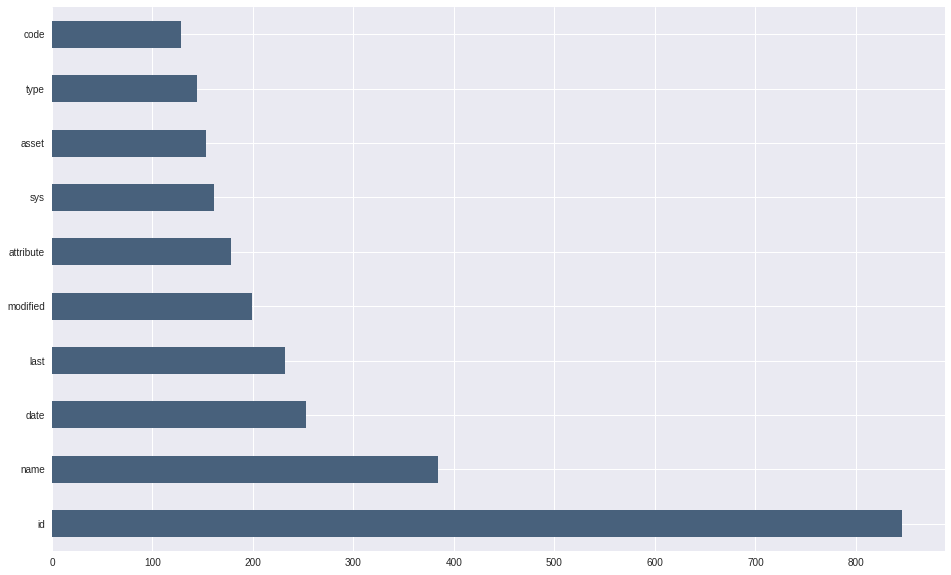

In [59]:
# top 10 words found in the Attribute_Technical_Names 
prep_tech_data = pre_process_text(data_no_paf["Attribute_Technical_Name"])
tech_word_list = sum(prep_tech_data, [])
tech_word_series = pd.Series(tech_word_list)
tech_word_series.value_counts()[:10].plot(kind="barh")
fig = plt.gcf()
fig.set_size_inches(16,10)
plt.show()

100%|██████████| 3941/3941 [00:00<00:00, 45570.28it/s]


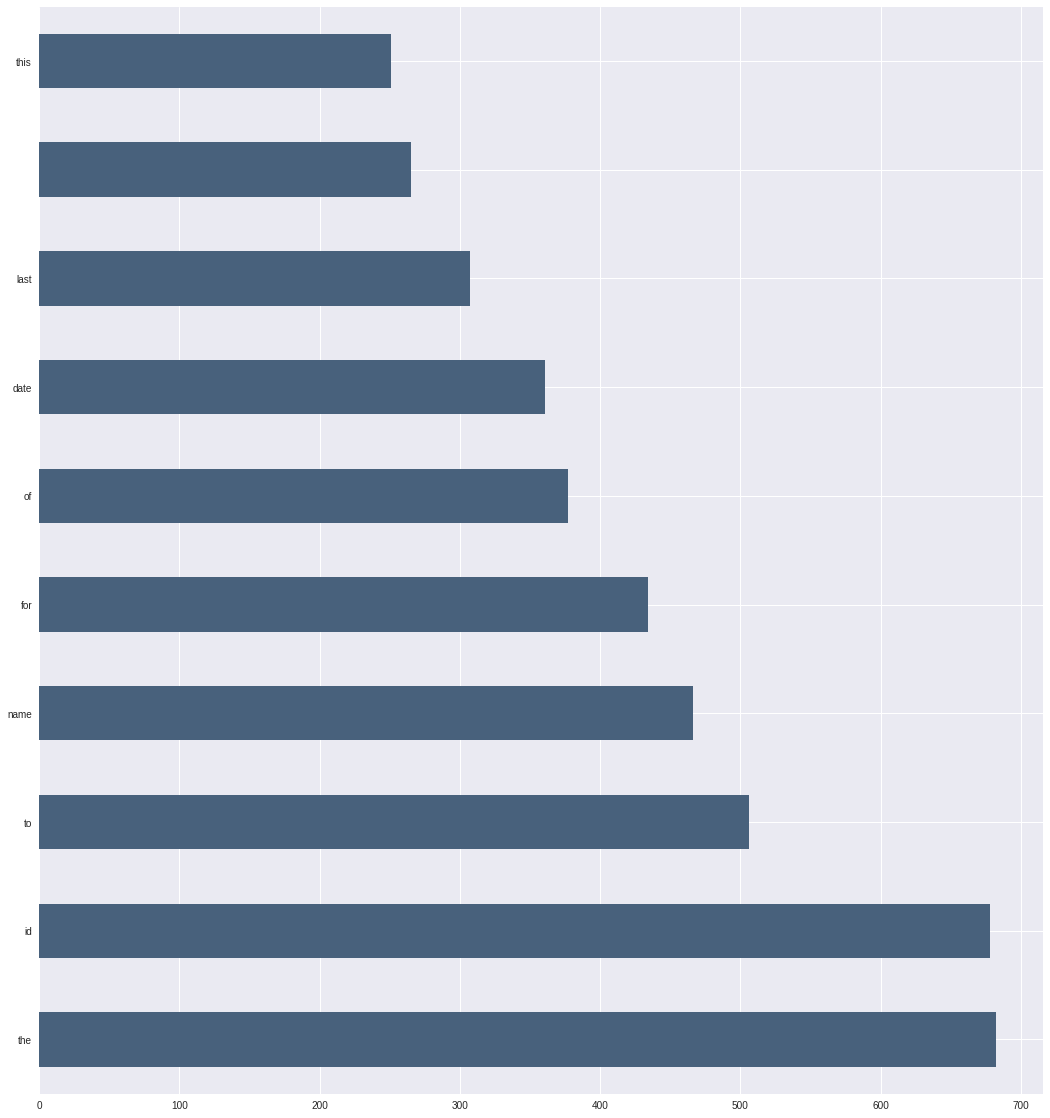

In [60]:
# top 10 words found in the Attribute_Business_Names 
prep_business_data= pre_process_text(data_no_paf["Attribute_Business_Name"])
business_word_list = sum(prep_business_data, [])
business_word_series = pd.Series(business_word_list)
business_word_series.value_counts()[:10].plot(kind="barh")
fig = plt.gcf()
fig.set_size_inches(18,20)
plt.show()

<a id='AN' name="AN"></a>
## [Word-, Label- and Character-level Analysis](#P0)

In [72]:
# word level number of unique values
print("Number of unique words in Attribute Business Names : " + str(business_word_series.nunique()))
print("Number of unique words in Attribute Technical Names : " + str(tech_word_series.nunique()))
print("Difference of the above : " + str(business_word_series.nunique()-tech_word_series.nunique()))

Number of unique words in Attribute Business Names : 1351
Number of unique words in Attribute Technical Names : 994
Difference of the above : 357


In [73]:
# label level number of unique values
print("Number of unique Attribute Business Names : " + str(data["Attribute_Business_Name"].nunique()))
print("Number of unique Attribute Technical Names : " + str(data["Attribute_Technical_Name"].nunique()))
print("Difference of the above : " + str(data["Attribute_Business_Name"].nunique()-data["Attribute_Technical_Name"].nunique()))

Number of unique Attribute Business Names : 2099
Number of unique Attribute Technical Names : 1998
Difference of the above : 101


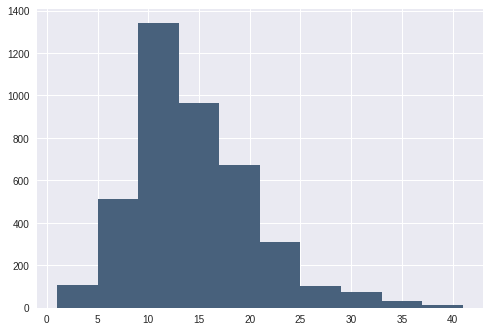

In [63]:
# histogram of string length in characters for original labels
data['Attribute_Technical_Name'].str.len().hist()
plt.show()

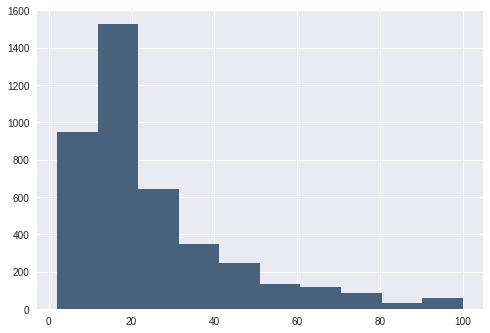

In [64]:
# as above in characters for business name
data['Attribute_Business_Name'].str.len().hist()
plt.show()

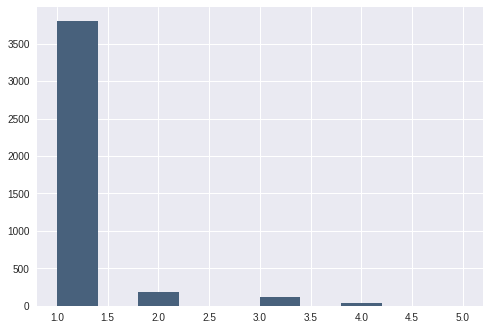

In [65]:
# histogram of string length in words for Technical Names
data.Attribute_Technical_Name.str.split().\
    map(lambda x: len(x)).\
    hist()
plt.show()

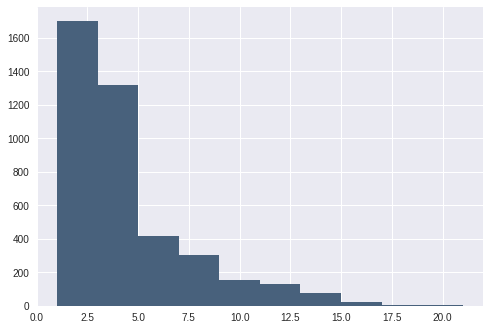

In [66]:
# histogram of string length in words for Business Name
data.Attribute_Business_Name.str.split().\
    map(lambda x: len(x)).\
    hist()
plt.show()

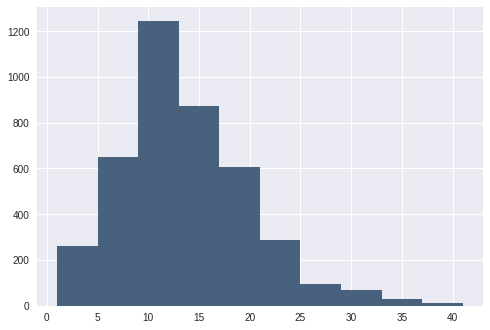

In [67]:
# average word length in characters for Technical Name
data['Attribute_Technical_Name'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()
plt.show()

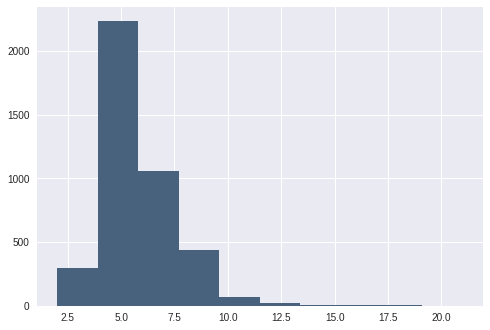

In [68]:
# average word length in characters for Business Name
data['Attribute_Business_Name'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()
plt.show()

<a id='ST' name="ST"></a>
## [Stopword Removal](#P0)

In this section we first check to see what the top stopwords in the Attribute Technical and Business Names are, then we plot the top words in each category without counting stopwords.

In [74]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [75]:
corpus=[]
new= data_no_paf['Attribute_Business_Name'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [76]:
# function to plot barchart for top stopwords
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)


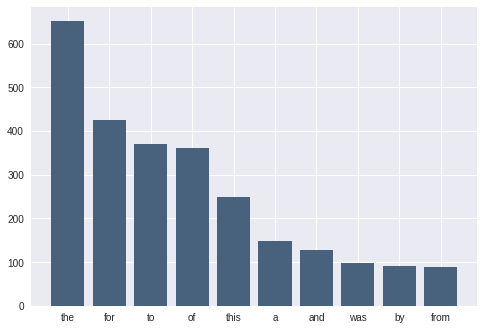

In [77]:
# top stopwords in Attribute Business Names
plot_top_stopwords_barchart(data_no_paf['Attribute_Business_Name'])

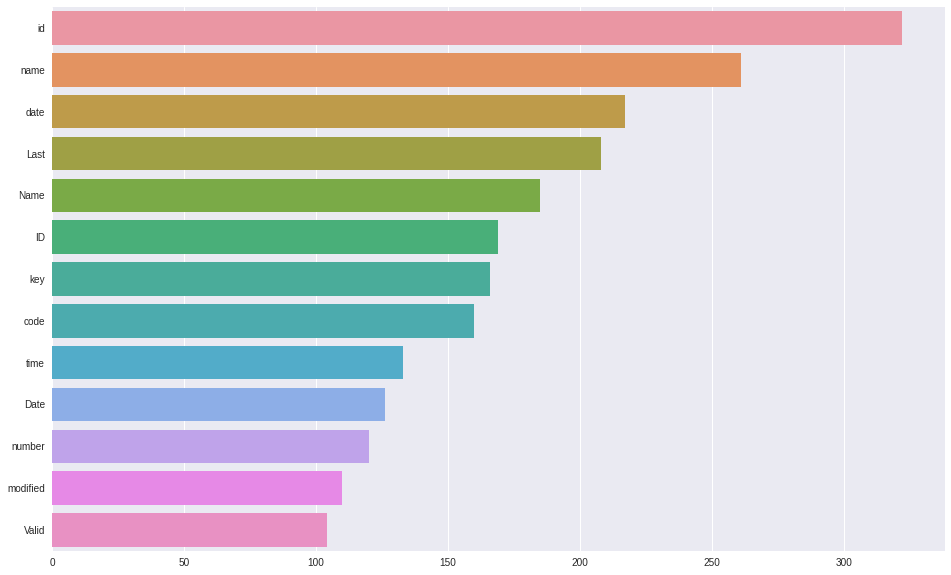

In [80]:
# optional: set a different color palette
# sns.color_palette("Spectral", as_cmap=True)

# top business words without stopwords
from collections import Counter

counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
fig1 = plt.gcf()
fig1.set_size_inches(16,10)
plt.show()


In [81]:
corpus=[]
new= data_no_paf['Attribute_Technical_Name'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

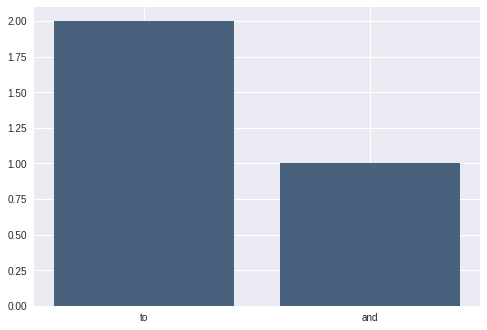

In [82]:
# top stopwords in Attribute Technical Names
plot_top_stopwords_barchart(data_no_paf['Attribute_Technical_Name'])

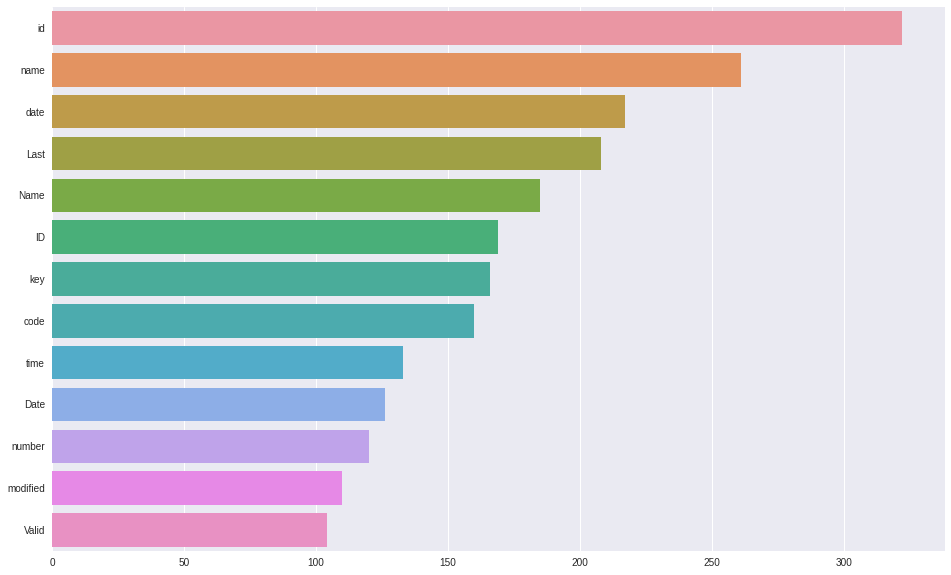

In [83]:
# top technical words without stopwords
from collections import Counter

counter=Counter(corpus)
most=counter.most_common()

a, b= [], []
for word,count in most[:20]:
    if (word not in stop):
        a.append(word)
        b.append(count)
        
sns.barplot(x=y,y=x)
fig2 = plt.gcf()
fig2.set_size_inches(16,10)
plt.show()

<a id='NG' name="NG"></a>
## [Top N-Grams in the Dataset](#P0)

In [84]:
list(ngrams(['I' ,'went','to','the','river','bank'],2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

In [85]:
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

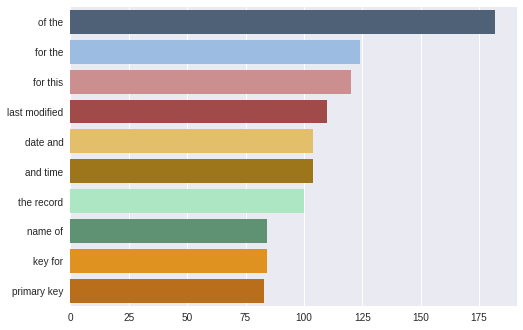

In [89]:
# Plot the top Bi-grams
sns.color_palette("Spectral", as_cmap=True)
top_n_bigrams_attribute_business_name = get_top_ngrams(data_no_paf["Attribute_Business_Name"],2)[:10]
x,y=map(list,zip(*top_n_bigrams_attribute_business_name)) 
sns.barplot(x=y,y=x)
plt.show()

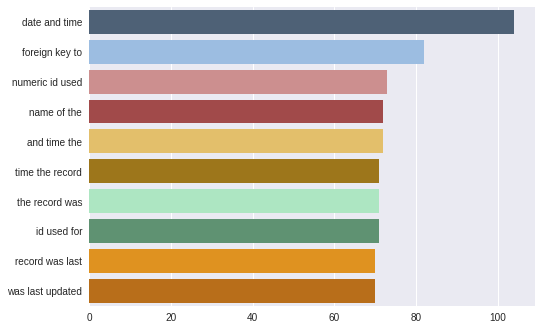

In [90]:
top_tri_grams_attribute_business_name=get_top_ngrams(data_no_paf['Attribute_Business_Name'],n=3)
x,y=map(list,zip(*top_tri_grams_attribute_business_name))
sns.barplot(x=y,y=x)
plt.show()

<a id='WC' name="WC"></a>
## [Wordcloud](#P0)

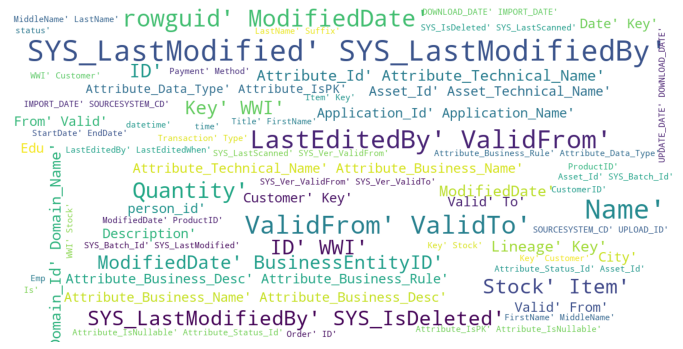

In [91]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# function to plot wordcloud
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
# wordcloud for Attribute Technical Names
show_wordcloud(corpus)

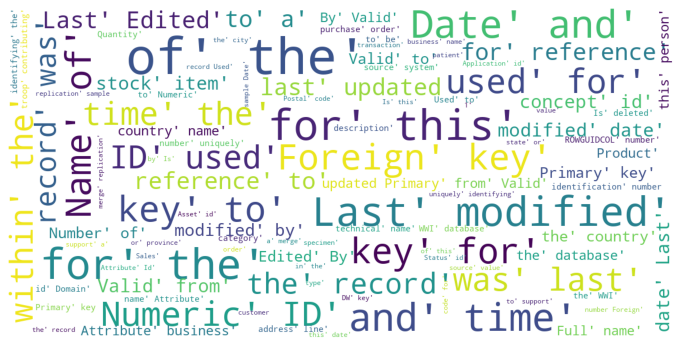

In [93]:
corpus=[]
new= data_no_paf['Attribute_Business_Name'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
# plot wordcloud for the Attribute Business Names
show_wordcloud(corpus)

<a id='CL'></a>
## [Conclusion](#P0)

- All in all we don't have any missings in the Attribute Business and Technical Names.
- Once the Data has been pre-processed using the function there are quite a few similar strings in both the Attribute Technical and Business Labels.
- String lengths are quite short for an NLP task
- Also, overall, although the dataset has 4500 rows, since the strings are so short, this is a small dataset for nlp processing. 

<div style="border-top:0.1cm solid #EF475B"></div>
    <strong><a href='#Q0'><div style="text-align: right"> <h3>End of this Notebook.</h3></div></a></strong>